# One Single Model Prediction

## Section 1: Data Preparation

### Import packages

In [1]:
from warnings import simplefilter
simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np
# models necessary to define the forecasting models 
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from forecast_combine.forecast import Forecast

### Lire les donnees

In [3]:
# set the seed for reproducibility
np.random.seed(41)
# generate an ARIMA process
data = pd.Series(np.cumsum(np.random.normal(0, 1, size=1000)), 
                 index=pd.date_range(end='31/12/2022', periods=1000)).rename('y').to_frame()
data.head(2)

,y
2020-04-06,-0.270712
2020-04-07,-0.165864


<Axes: >

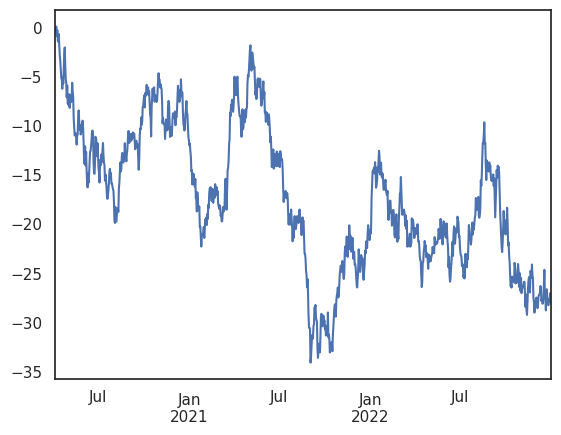

In [4]:
data.y.plot()

## Section 2: Model Definition

In [5]:
model = StatsForecastAutoARIMA(n_jobs = 4, trend=True, seasonal=True, max_p= 10, max_q=10)

In [6]:
LF = Forecast(data = data,
                          depvar_str='y',      
                          exog_l= None,
                          forecaster_name = 'AutoARIMA',
                          forecaster= model,
                          fh = 5,
                          pct_initial_window = 0.5,
                          step_length = 25, 
                          freq = 'B')

In [7]:
LF.split_procedure_summary()

{'Number of Folds': 15,
 'Initial Window Size': 357,
 'Step Length': 25,
 'Forecast period': 5,
 'First Cutoff': 0,
 'Last Curoff': 0}

## Section 3: In-sample vs Out-Of-smaple

### Cross validation Procedure

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'Insample vs Out-Of-Sample'}, ylabel='y'>)

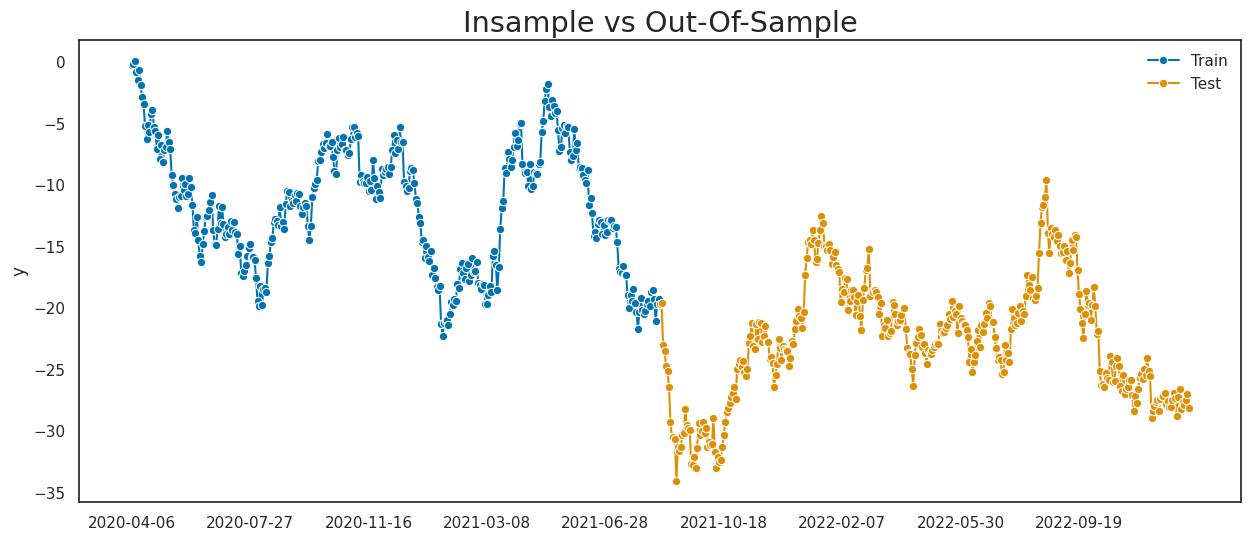

In [8]:
LF.plot.plot_train_test(
    labels = ['Train', 'Test'],
    title='Insample vs Out-Of-Sample')

<Axes: title={'center': 'Cross Validation Procedure'}, ylabel='Window number'>

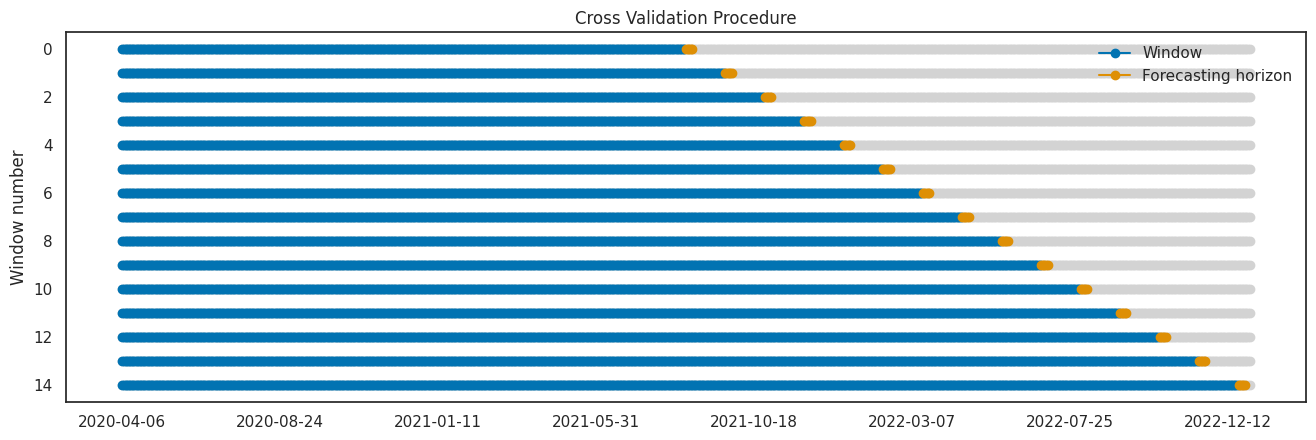

In [9]:
LF.plot.plot_cv_procedure(xlabel='')

### Fit

In [10]:
lf_fit= LF.fit(on='train')

In [11]:
lf_fit.insample_result_df

### In Sample Evaluation

In [12]:
pred = lf_fit.insample_predictions(nsample =200)
display(pred.head())

200it [00:02, 89.81it/s]


,index,y_pred,y_true,Abs_diff,horizon,cutoff
0,2020-04-09,0.084664,-0.840536,0.925200,1,2020-04-08
1,2020-04-10,-0.840536,-1.467249,0.626713,2,2020-04-08
2,2020-04-13,-1.467249,-0.677397,0.789852,3,2020-04-08
3,2020-04-14,-0.677397,-1.903613,1.226216,4,2020-04-08
4,2020-04-15,-1.903613,-2.851620,0.948007,5,2020-04-08


In [13]:
insample_perf_summary = lf_fit.insample_perf()

In [14]:
display(insample_perf_summary['cutoff'].head())
display(insample_perf_summary['horizon'].head())

,RMSE,MAE,MAPE,R2,MedianAE
cutoff,,,,,
2020-04-08,0.924657,0.903197,73.409339,-0.383095,0.925200
2020-04-09,0.865270,0.832088,54.724896,0.214720,0.789852
2020-04-10,1.142315,1.063044,53.030461,0.431188,0.948007
2020-04-13,1.180453,1.111646,33.023029,0.440982,1.032859
2020-04-14,1.163519,1.094888,24.626081,0.123251,1.032859


,RMSE,MAE,MAPE,R2,MedianAE
horizon,,,,,
1,1.078129,0.867898,10.527558,0.952960,0.752992
2,1.103986,0.871297,10.069774,0.952110,0.697119
3,1.101986,0.871096,10.310831,0.951477,0.723697
4,1.113124,0.878568,9.553218,0.950567,0.712590
5,1.123072,0.901943,9.579380,0.947379,0.751962


(<Figure size 1500x500 with 2 Axes>,
 array([<Axes: title={'center': 'RMSE By cutoff'}>,
        <Axes: title={'center': 'RMSE By horizon'}>], dtype=object))

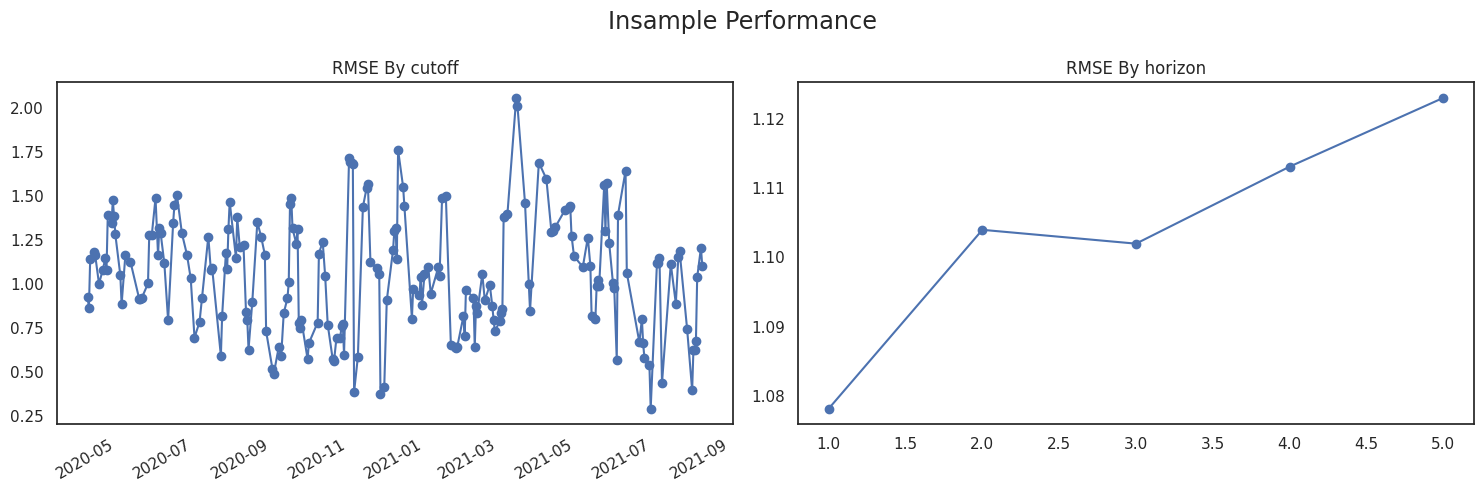

In [15]:
lf_fit.plot.plot_insample_performance(metric='RMSE')

(<Figure size 1500x500 with 2 Axes>,
 array([<Axes: title={'center': 'MAPE By cutoff'}>,
        <Axes: title={'center': 'MAPE By horizon'}>], dtype=object))

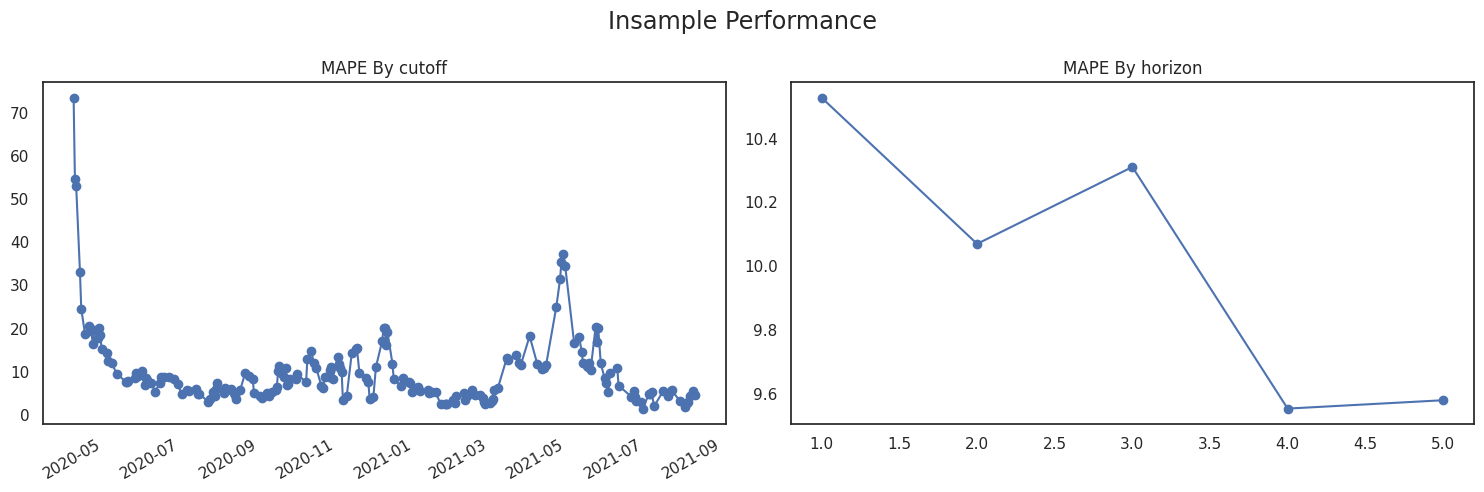

In [16]:
lf_fit.plot.plot_insample_performance(metric='MAPE')

### Out-Of-sample Evaluation

In [17]:
lf_eval= LF.evaluate()


Start forecaster AutoARIMA evalution....
 Depending on the forecaster this step may take couple of minutes. Please don't kill the kernel
Evaluation time: 0.072 minutes


In [18]:
lf_eval.summary_results()

,Number of Folds,Avg Fit time (s),Avg_pred_time (s),Smallest training window,Largest training window,First cutoff,Last cutoff,Avg MAPE,Avg RMSE
0,15,0.194649,0.075929,357,707,2021-08-17,2022-12-20,0.061749,1.575342


In [19]:
lf_eval.summary_horizon()

,RMSE,MAE,MAPE,R2,MedianAE
horizon,,,,,
1,1.062702,0.805211,3.781202,0.945026,0.533539
2,1.482809,1.141388,5.177030,0.873053,1.090564
3,1.745825,1.448386,6.270489,0.819032,1.099761
4,1.981371,1.613314,7.438958,0.794348,1.315591
5,2.364701,1.902159,8.206872,0.652576,1.469133


<Axes: title={'center': 'Out of Sample Performance - Average on All Horizons'}, ylabel='MAPE'>

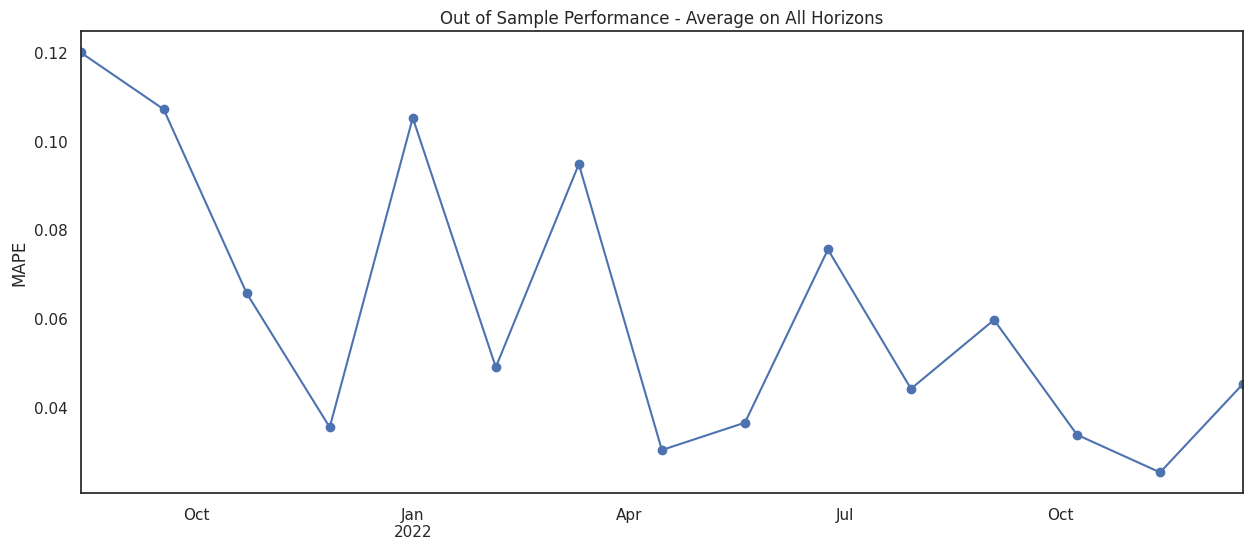

In [20]:
lf_eval.plot.plot_oos_score(score = 'MAPE')

Computing summary performance per horizon ...


<Axes: title={'center': 'Out of Sample Performance - Average per Horizons'}, xlabel='Horizon', ylabel='MAPE'>

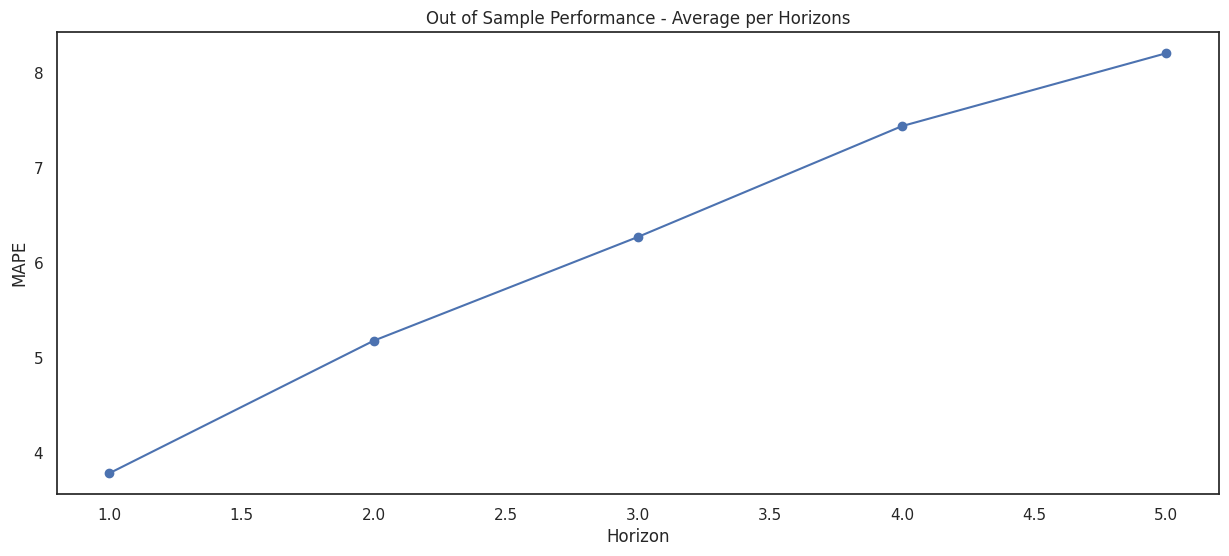

In [21]:
lf_eval.plot.plot_oos_horizon(score = 'MAPE', xlabel = 'Horizon')

## Section 4: Generate predictions

In [22]:
# First Fit on all the sample
LF.fit(on ='all')
# Predict
y_pred, y_pred_ints = LF.predict()

(<Figure size 1300x500 with 1 Axes>,
 <Axes: title={'center': 'ARIMA Prediction'}, ylabel='y'>)

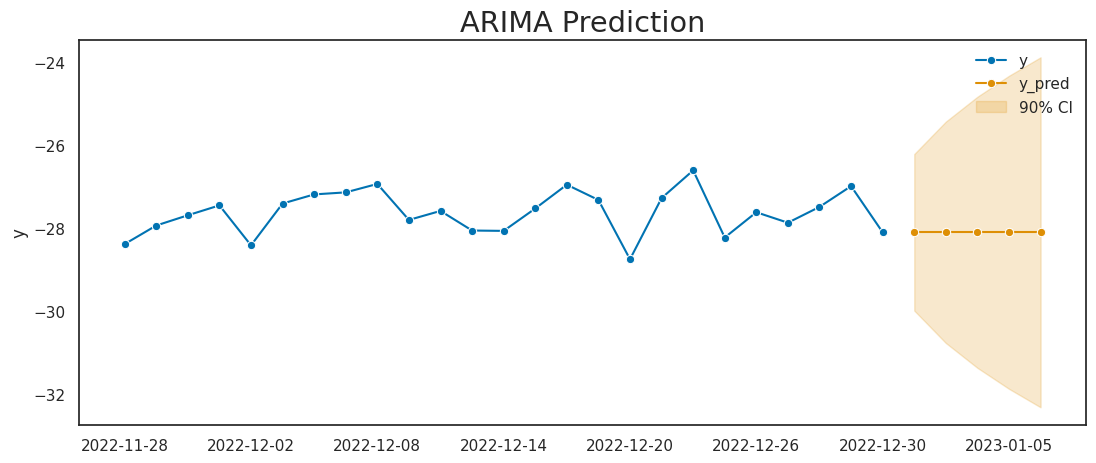

In [24]:
LF.plot.plot_prediction(y_pred, y_pred_ints, 
                        labels=['y', 'y_pred'], 
                        title = 'ARIMA Prediction', 
                        figsize = (13,5))

### Section 5: Update Predictions when new data comes in

In [25]:
# create a dataframe with the new data
newdata = pd.concat([data, 
                     pd.DataFrame(index=[y_pred.index[0]], columns =data.columns)
                    ])
newdata.loc[y_pred.index[0], 'BMC'] = y_pred.iloc[0]
newdata = newdata.ffill()
newdata.tail()

,y,BMC
2022-12-28,-27.488310,NaN
2022-12-29,-26.987324,NaN
2022-12-30,-27.541588,NaN
2022-12-31,-28.100736,NaN
2023-01-02,-28.100736,-28.100736


### Either with or without refitting the model

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'Prediction'}, ylabel='y'>)

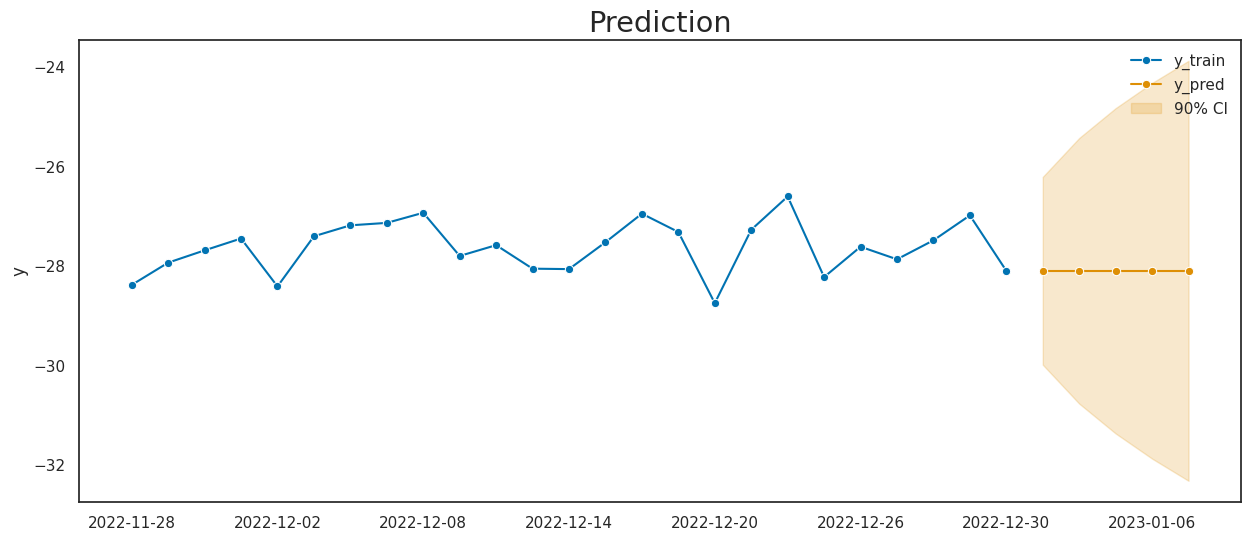

In [26]:
y_pred, y_pred_ints = LF.update(newdata = newdata, refit=False)
LF.plot.plot_prediction(y_pred, y_pred_ints)